<a href="https://colab.research.google.com/github/MSaber9/DL/blob/master/CatDog_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cat / Dog Image Classification


## Library

In [0]:
%matplotlib inline

import sys
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from tensorflow.keras import layers
from tensorflow.keras import Model
from keras.layers import Dropout
from keras.preprocessing.image import ImageDataGenerator

from keras.layers import Activation, BatchNormalization
from keras.applications.vgg16 import VGG16

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model


## Loading Data

In [84]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-01-14 03:04:59--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.126.128, 2a00:1450:4013:c01::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.126.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   206MB/s    in 0.3s    

2020-01-14 03:04:59 (206 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [6]:
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

['cat.20.jpg', 'cat.6.jpg', 'cat.593.jpg', 'cat.418.jpg', 'cat.979.jpg', 'cat.443.jpg', 'cat.492.jpg', 'cat.855.jpg', 'cat.894.jpg', 'cat.573.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


In [7]:
# total number of cat and dog images in the train and validation directories
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


Display a batch of 8 cat and 8 dog pictures:

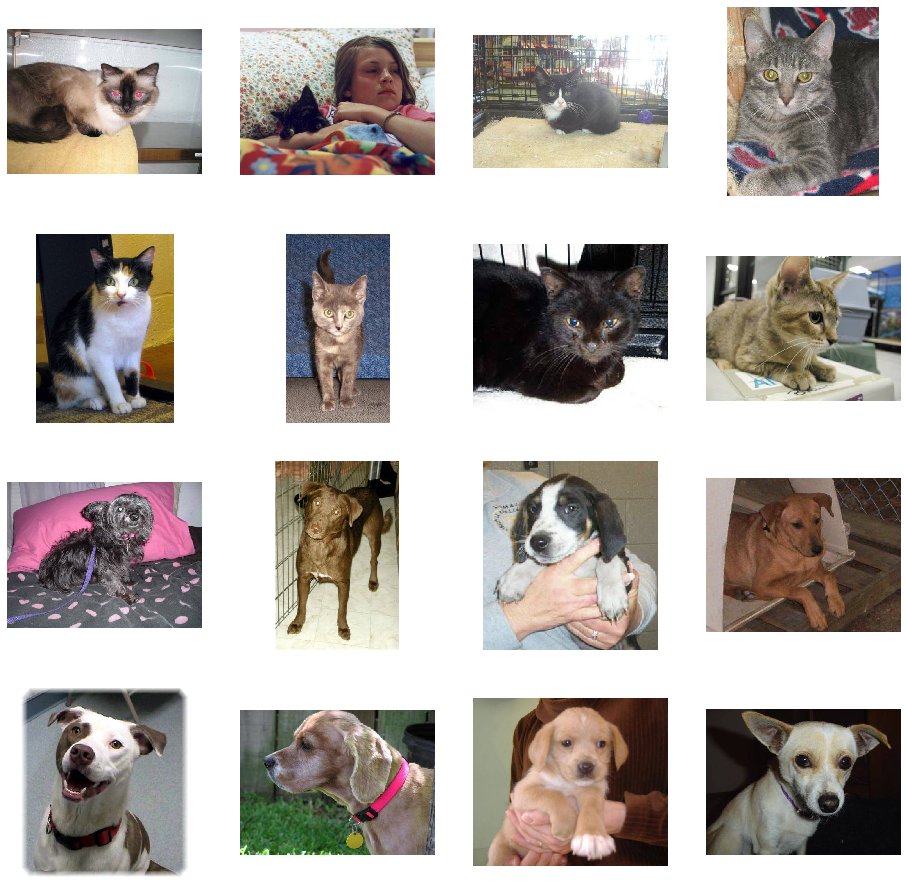

In [10]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


## Data Preprocessing



In [85]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(200, 200),  # All images will be resized to 200x200
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(200, 200),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Building a ConvNet Models

### Model A

In [0]:
def ModelA():
  modelA = Sequential()

  modelA.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
  modelA.add(MaxPooling2D((2, 2)))
  modelA.add(Flatten())

  modelA.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  modelA.add(Dense(1, activation='sigmoid'))
  modelA.summary()

	# compile model
  opt = SGD(lr=0.001, momentum=0.9)
  modelA.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

  return modelA

In [0]:
def RunModel(model):
  history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=15,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2)
  return history

In [0]:
def plotModel(MyHistory):
  # Retrieve a list of accuracy results on training and validation data
  # sets for each training epoch
  acc = MyHistory.history['acc']
  val_acc = MyHistory.history['val_acc']

  # Retrieve a list of list results on training and validation data
  # sets for each training epoch
  loss = MyHistory.history['loss']
  val_loss = MyHistory.history['val_loss']

  # Get number of epochs
  epochs = range(len(acc))

  # Plot training and validation accuracy per epoch
  pyplot.subplot(211)
  pyplot.plot(epochs, acc)
  pyplot.plot(epochs, val_acc)
  pyplot.title('Training and validation accuracy')

  pyplot.figure()

  # Plot training and validation loss per epoch
  pyplot.subplot(211)
  pyplot.plot(epochs, loss)
  pyplot.plot(epochs, val_loss)
  pyplot.title('Training and validation loss')

In [90]:
historyA = RunModel(ModelA())

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 200, 200, 32)      896       
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 100, 100, 32)      0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 320000)            0         
_________________________________________________________________
dense_29 (Dense)             (None, 128)               40960128  
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 129       
Total params: 40,961,153
Trainable params: 40,961,153
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
 - 11s - loss: 0.7645 - acc: 0.4925 - val_loss: 0.6930 - val_acc: 0.5020
Epoch 2/15
 - 9s - loss

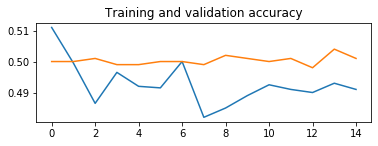

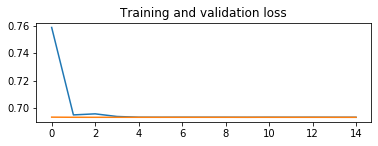

In [61]:
 plotModel(historyA)

### Model B

In [0]:
def ModelB():
  modelB = Sequential()
  
  modelB.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
  modelB.add(MaxPooling2D((2, 2)))
  
  modelB.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  modelB.add(MaxPooling2D((2, 2)))
  modelB.add(Flatten())
  
  modelB.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  modelB.add(Dense(1, activation='sigmoid'))
  modelB.summary()

	# compile model
  opt = SGD(lr=0.001, momentum=0.9)
  modelB.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  
  return modelB

In [54]:
historyB = RunModel(ModelB())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 200, 200, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 100, 100, 64)      18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 50, 50, 64)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 160000)            0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               20480128  
_________________________________________________________________
dense_16 (Dense)             (None, 1)                

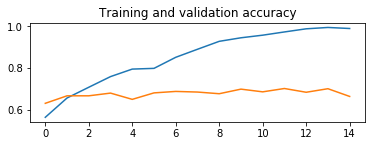

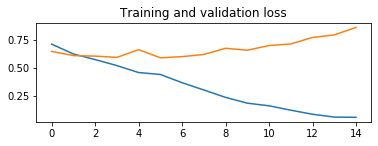

In [62]:
plotModel(historyB)

### Model C

In [0]:
def ModelC():
  modelC = Sequential()
  modelC.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
  modelC.add(MaxPooling2D((2, 2)))

  modelC.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  modelC.add(MaxPooling2D((2, 2)))

  modelC.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  modelC.add(MaxPooling2D((2, 2)))
  modelC.add(Flatten())

  modelC.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  modelC.add(Dense(1, activation='sigmoid'))
 
  # compile model
  opt = SGD(lr=0.001, momentum=0.9)
  modelC.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  modelC.summary()

  return modelC

In [66]:
historyC = RunModel(ModelC())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 200, 200, 32)      896       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 100, 100, 64)      18496     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 50, 50, 128)       73856     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 25, 25, 128)       0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 80000)           

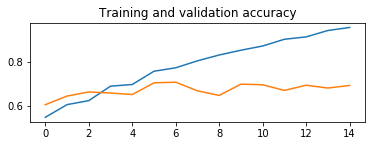

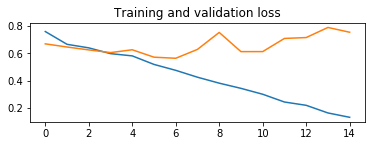

In [68]:
 plotModel(historyC)

### Model D

In [0]:
def ModelD():
  modelD = Sequential()
  modelD.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
  modelD.add(MaxPooling2D((2, 2)))

  modelD.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  modelD.add(MaxPooling2D((2, 2)))

  modelD.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  modelD.add(MaxPooling2D((2, 2)))

  modelD.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  modelD.add(MaxPooling2D((2, 2)))
  modelD.add(Flatten())

  modelD.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  modelD.add(Dense(1, activation='sigmoid'))
 
  # compile model
  opt = SGD(lr=0.001, momentum=0.9)
  modelD.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  modelD.summary()

  return modelD

In [74]:
historyD = RunModel(ModelD())

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 200, 200, 32)      896       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 100, 100, 64)      18496     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 50, 50, 128)       73856     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 25, 25, 128)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 25, 25, 256)     

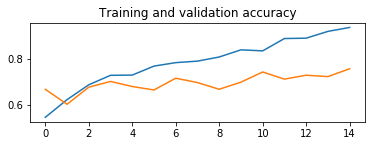

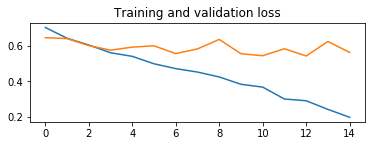

In [75]:
 plotModel(historyD)

### Model E

In [0]:
def ModelE():
  modelE = Sequential()

  modelE.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
  modelE.add(MaxPooling2D((2, 2)))
  modelE.add(Dropout(0.2))

  modelE.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  modelE.add(MaxPooling2D((2, 2)))
  modelE.add(Dropout(0.2))

  modelE.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  modelE.add(MaxPooling2D((2, 2)))
  modelE.add(Dropout(0.2))
  modelE.add(Flatten())

  modelE.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  modelE.add(Dropout(0.5))
  modelE.add(Dense(1, activation='sigmoid'))
 
  # compile model
  opt = SGD(lr=0.001, momentum=0.9)
  modelE.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  modelE.summary()

  return modelE

In [98]:
historyE = RunModel(ModelE())

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_47 (Conv2D)           (None, 200, 200, 32)      896       
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 100, 100, 32)      0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 100, 100, 64)      18496     
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 50, 50, 64)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 50, 50, 128)     

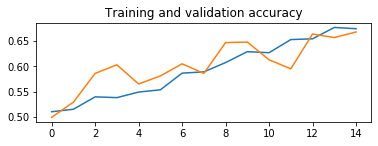

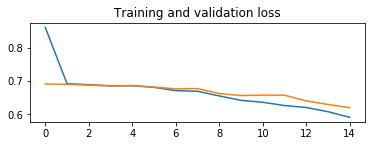

In [103]:
 plotModel(historyE)

In [0]:
def RunModel50 (model):
  history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=50,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2)
  return history

In [106]:
historyE50 = RunModel50(ModelE())

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_56 (Conv2D)           (None, 200, 200, 32)      896       
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 100, 100, 32)      0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 100, 100, 64)      18496     
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 50, 50, 64)        0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 50, 50, 128)     

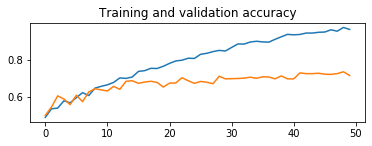

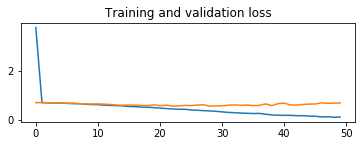

In [136]:
 plotModel(historyE50)

### Model F

In [108]:
# create data generators
train_datagen = ImageDataGenerator(rescale=1.0/255.0, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# prepare iterators
train_it = train_datagen.flow_from_directory(
          train_dir, 
          target_size=(200, 200),
          batch_size=64,
          class_mode='binary')


test_it = test_datagen.flow_from_directory(
          validation_dir,
          target_size=(200, 200),
          batch_size=64,
          class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
def ModelF():
    modelF = Sequential()
  
    modelF.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
    modelF.add(MaxPooling2D((2, 2)))
  
    modelF.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    modelF.add(MaxPooling2D((2, 2)))
  
    modelF.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    modelF.add(MaxPooling2D((2, 2)))
    modelF.add(Flatten())
  
    modelF.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    modelF.add(Dense(1, activation='sigmoid'))
  
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    modelF.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    modelF.summary()

    return modelF

In [0]:
def RunModelGen(model):
    history = model.fit_generator(
        train_it, 
        steps_per_epoch=len(train_it),
        validation_data=test_it, 
        validation_steps=len(test_it), 
        epochs=50, 
        verbose=1)
        
    # evaluate model
    _, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
    print('> %.3f' % (acc * 100.0))

    return history

In [157]:
historyF = RunModelGen(ModelF())

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_113 (Conv2D)          (None, 200, 200, 32)      896       
_________________________________________________________________
max_pooling2d_113 (MaxPoolin (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_114 (Conv2D)          (None, 100, 100, 64)      18496     
_________________________________________________________________
max_pooling2d_114 (MaxPoolin (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_115 (Conv2D)          (None, 50, 50, 128)       73856     
_________________________________________________________________
max_pooling2d_115 (MaxPoolin (None, 25, 25, 128)       0         
_________________________________________________________________
flatten_42 (Flatten)         (None, 80000)           

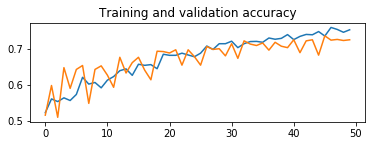

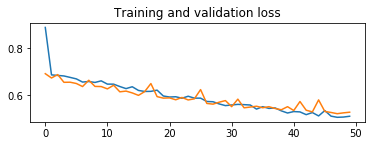

In [158]:
 plotModel(historyF)

In [163]:
historyEG = RunModelGen(ModelE()) # Apply Drop + Data Generation 

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_116 (Conv2D)          (None, 200, 200, 32)      896       
_________________________________________________________________
max_pooling2d_116 (MaxPoolin (None, 100, 100, 32)      0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_117 (Conv2D)          (None, 100, 100, 64)      18496     
_________________________________________________________________
max_pooling2d_117 (MaxPoolin (None, 50, 50, 64)        0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_118 (Conv2D)          (None, 50, 50, 128)     

### VGG : Explore Transfer Learning


```
# This is formatted as code
```



In [199]:
	# Create data generator
	datagen = ImageDataGenerator(featurewise_center=True)
 
	# specify imagenet mean values for centering
	datagen.mean = [123.68, 116.779, 103.939]

	# prepare iterator
	train_it = datagen.flow_from_directory(train_dir, class_mode='binary', batch_size=64, target_size=(224, 224))
	test_it = datagen.flow_from_directory(validation_dir, class_mode='binary', batch_size=64, target_size=(224, 224))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
def modelV():
    # load model
    model = VGG16(include_top=False, input_shape=(224, 224, 3))

    # mark loaded layers as not trainable
    for layer in model.layers:
      layer.trainable = False

    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(1, activation='sigmoid')(class1)

    # define new model
    model = Model(inputs=model.inputs, outputs=output)

    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()

    return model

In [0]:
def RunModelV(model):
    # fit model
    history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
      validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=2)
    
    # save model
    model.save('final_model.h5')

    return history

In [218]:
historyV = RunModelV(modelV())

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

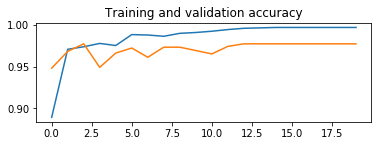

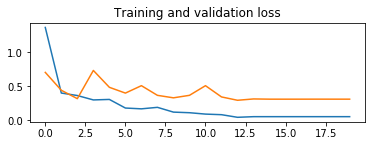

In [219]:
 plotModel(historyV)

## Make Prediction

This is CAT


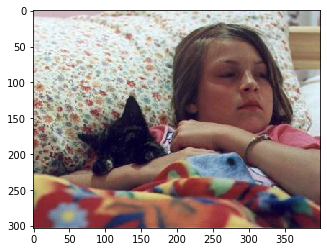

In [246]:
# load and prepare the image
def load_image(filename):
	# load the image
	img = load_img(filename, target_size=(224, 224))
	# convert to array
	img = img_to_array(img)
	# reshape into a single sample with 3 channels
	img = img.reshape(1, 224, 224, 3)
	# center pixel data
	img = img.astype('float32')
	img = img - [123.68, 116.779, 103.939]
	return img

# load an image and predict the class
def run_example():
    # load the image
    img = load_image(img_path)
    # load model
    model = load_model('final_model.h5')
    # predict the class
    result = model.predict(img)

    if result == 0:
      print ('This is CAT')
    if result == 1 :
      print ('This is DOG')

img_path = train_cats_dir + '/' + 'cat.6.jpg'
img = mpimg.imread(img_path)
plt.imshow(img)

# entry point, run the example
run_example()

## Plot Evaluating Accuracy and Loss for the My Model


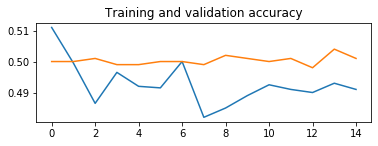

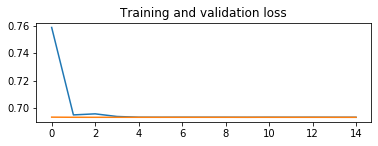

In [59]:
 plotModel(historyA)

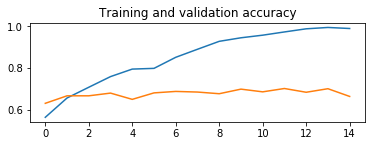

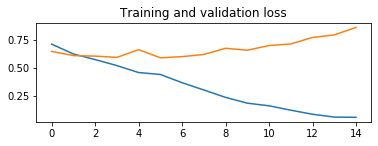

In [60]:
 plotModel(historyB)

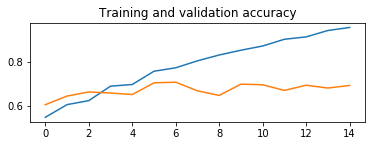

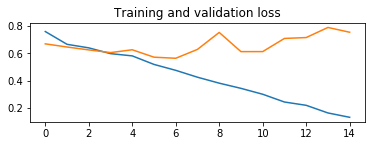

In [69]:
 plotModel(historyC)

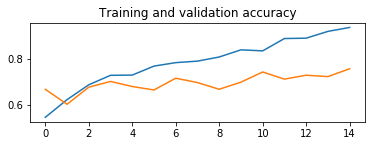

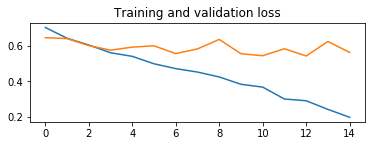

In [77]:
 plotModel(historyD)

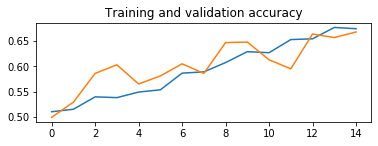

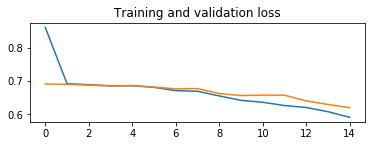

In [159]:
plotModel(historyE)

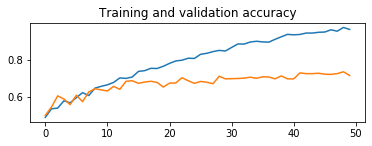

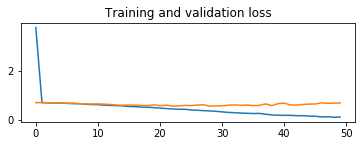

In [160]:
plotModel(historyE50)

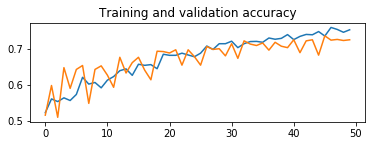

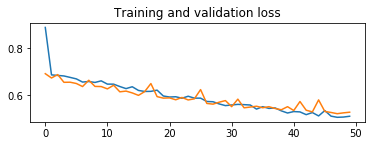

In [161]:
plotModel(historyF)

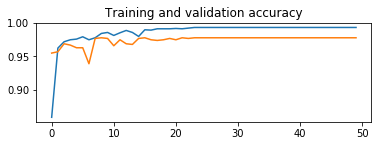

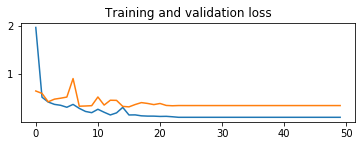

In [214]:
plotModel(historyV)

## Clean Up

Before running the next exercise, run the following cell to terminate the kernel and free memory resources:

In [0]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)